In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!gdown 1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1

Downloading...
From (original): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1
From (redirected): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1&confirm=t&uuid=f9071c07-be17-43d3-9c90-91184bd29c10
To: /content/journey-springfield.zip
100% 546M/546M [00:15<00:00, 35.9MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('journey-springfield.zip', 'r') as zip_ref:
    zip_ref.extractall('./content/')

In [ ]:
from pathlib import Path

TRAIN_DIR = Path('/content/content/train')
TEST_DIR = Path('/content/content/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

 Всего изображений: 20933
 Количество классов: 42


/tmp/ipython-input-755537297.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=char_counts.values, y=char_counts.index, palette='viridis')


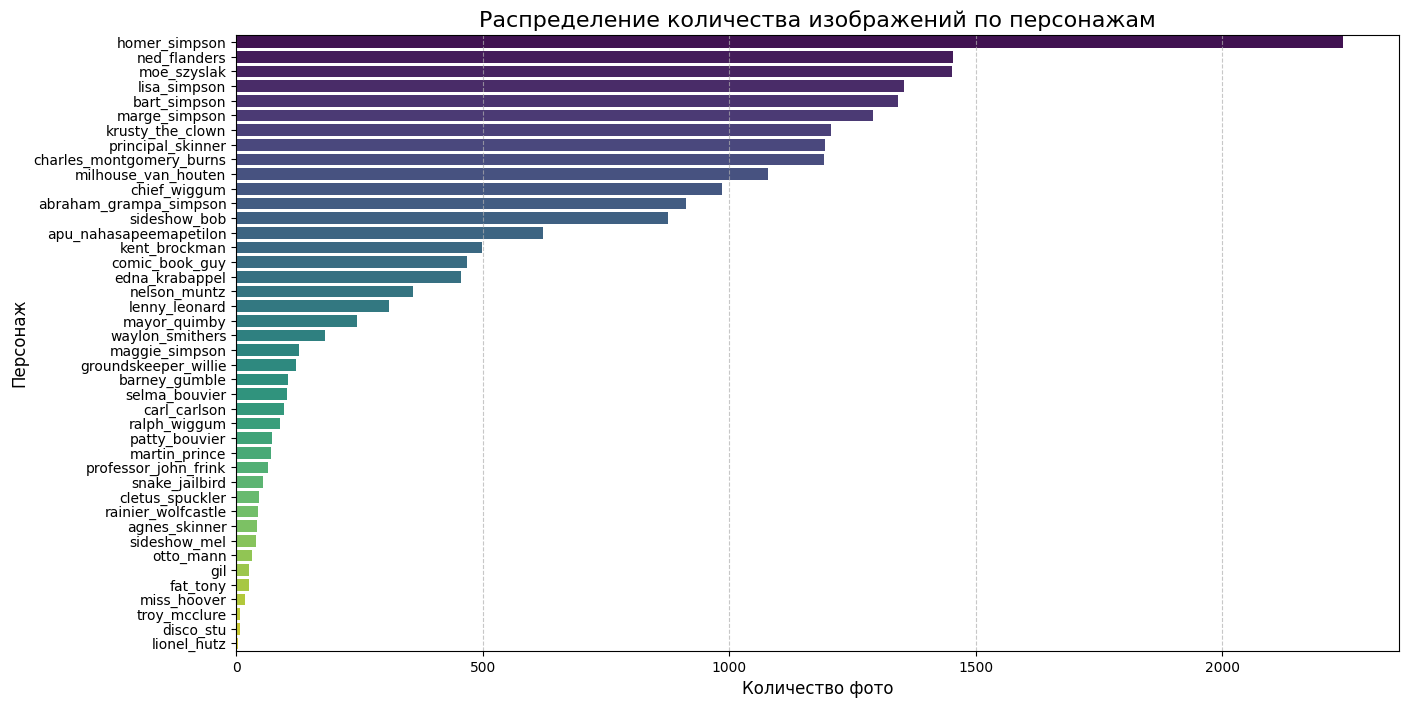

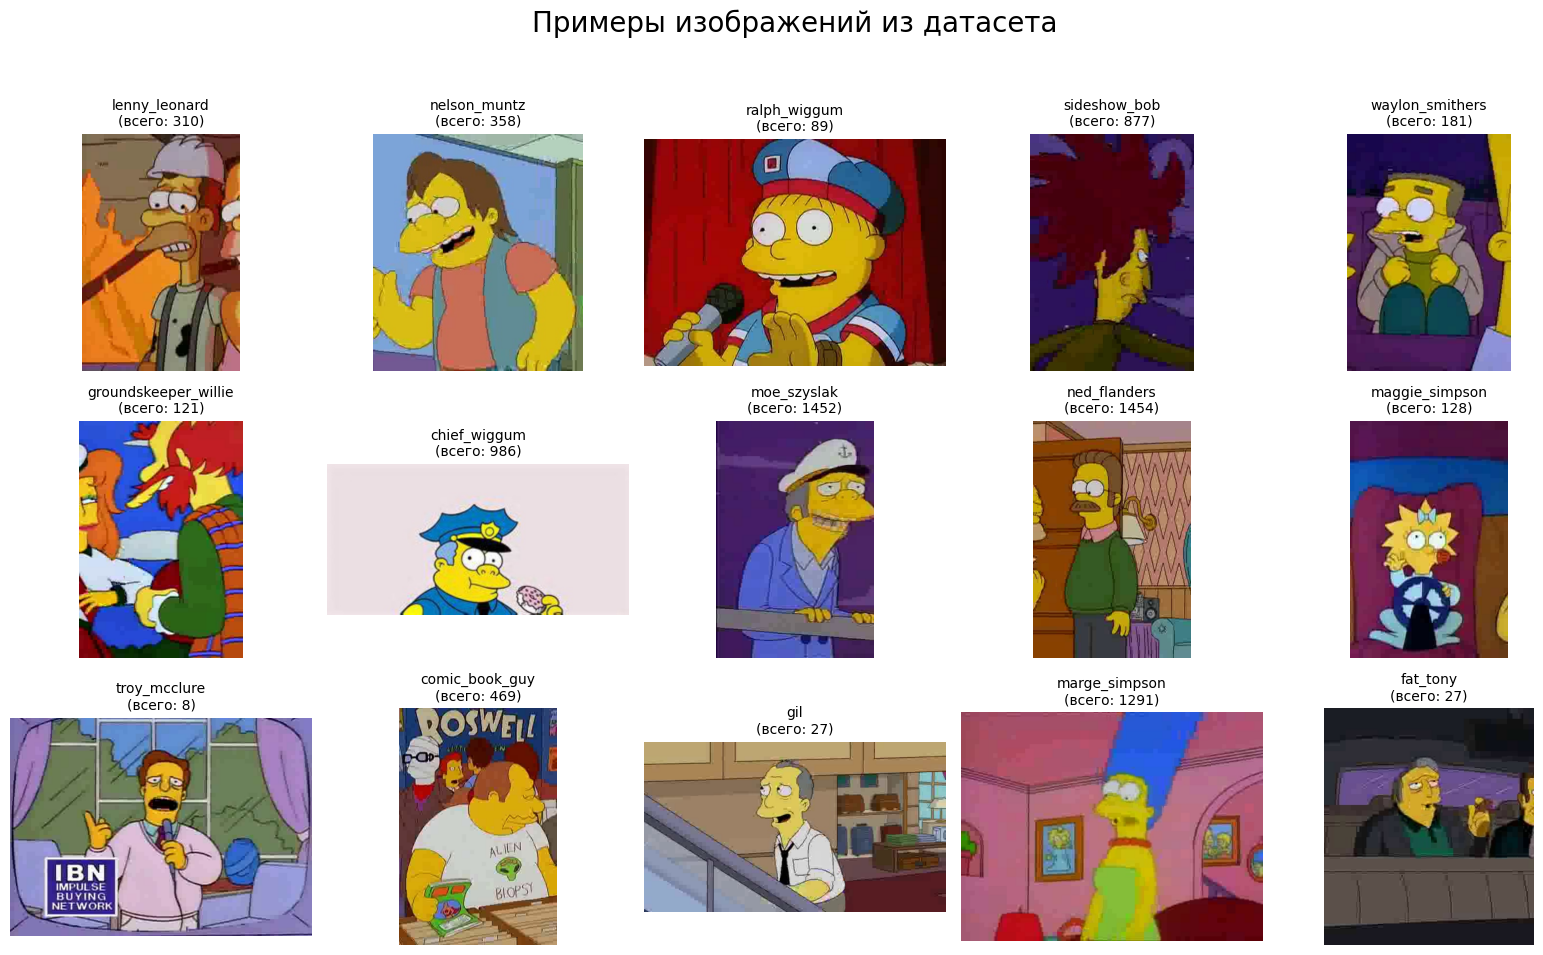

In [ ]:
#анализ и визуализация исходных данных
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from pathlib import Path
from PIL import Image

def explore_data(train_dir):
    all_files = list(Path(train_dir).rglob('*.jpg'))
    data = []
    for f in all_files:
        data.append({'path': str(f), 'character': f.parent.name})

    df = pd.DataFrame(data)

    print(f" Всего изображений: {len(df)}")
    print(f" Количество классов: {df['character'].nunique()}")

    plt.figure(figsize=(15, 8))
    char_counts = df['character'].value_counts()
    sns.barplot(x=char_counts.values, y=char_counts.index, palette='viridis')
    plt.title('Распределение количества изображений по персонажам', fontsize=16)
    plt.xlabel('Количество фото', fontsize=12)
    plt.ylabel('Персонаж', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.suptitle('Примеры изображений из датасета', fontsize=20)

    unique_chars = df['character'].unique()
    sample_chars = random.sample(list(unique_chars), min(15, len(unique_chars)))

    for i, char in enumerate(sample_chars):
        plt.subplot(3, 5, i + 1)
        char_df = df[df['character'] == char]
        img_path = random.choice(char_df['path'].values)
        img = Image.open(img_path)

        plt.imshow(img)
        plt.title(f"{char}\n(всего: {len(char_df)})", fontsize=10)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

explore_data(TRAIN_DIR)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
IMG_SIZE = 224

In [ ]:
files = train_val_files
labels = [f.parent.name for f in files]

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [ ]:
# аугментация и Dataset
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class SimpsonsDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]

In [ ]:
# создание DataLoader с балансировкой
train_f, val_f, train_l, val_l = train_test_split(
    files, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

weights = 1. / np.bincount(train_l)
samples_weights = weights[train_l]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

train_loader = DataLoader(SimpsonsDataset(train_f, train_l, train_transforms), batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(SimpsonsDataset(val_f, val_l, val_transforms), batch_size=BATCH_SIZE)

In [ ]:
# создание модели
def get_model(num_classes):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    # Заменяем классификатор
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    )
    return model.to(DEVICE)

model = get_model(len(encoder.classes_))

In [ ]:
#обучение
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    history = {'train_loss': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                out = model(x.to(DEVICE))
                all_preds.extend(out.argmax(1).cpu().numpy())
                all_labels.extend(y.numpy())

        f1 = f1_score(all_labels, all_preds, average='macro')

        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}: Loss {avg_train_loss:.4f} | Val F1: {f1:.4f} | LR: {current_lr:.6f}")

        history['train_loss'].append(avg_train_loss)
        history['val_f1'].append(f1)

        scheduler.step()

    return history

history = train_model(model, train_loader, val_loader, epochs=10)

Epoch 1:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 1: Loss 0.5244 | Val F1: 0.8047 | LR: 0.001000


Epoch 2:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 2: Loss 0.1100 | Val F1: 0.8714 | LR: 0.000976


Epoch 3:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 3: Loss 0.0791 | Val F1: 0.8464 | LR: 0.000905


Epoch 4:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 4: Loss 0.0508 | Val F1: 0.9242 | LR: 0.000794


Epoch 5:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 5: Loss 0.0313 | Val F1: 0.8787 | LR: 0.000655


Epoch 6:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 6: Loss 0.0236 | Val F1: 0.9172 | LR: 0.000501


Epoch 7:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 7: Loss 0.0159 | Val F1: 0.9520 | LR: 0.000346


Epoch 8:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 8: Loss 0.0143 | Val F1: 0.9497 | LR: 0.000207


Epoch 9:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 9: Loss 0.0062 | Val F1: 0.9576 | LR: 0.000096


Epoch 10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 10: Loss 0.0058 | Val F1: 0.9587 | LR: 0.000025


In [ ]:
# построение Classification Report
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        out = model(x.to(DEVICE))
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.numpy())

print(classification_report(all_labels, all_preds, target_names=encoder.classes_))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.99      0.98       183
           agnes_skinner       1.00      1.00      1.00         8
  apu_nahasapeemapetilon       0.99      0.97      0.98       125
           barney_gumble       0.90      0.90      0.90        21
            bart_simpson       0.99      0.97      0.98       268
            carl_carlson       0.95      1.00      0.98        20
charles_montgomery_burns       0.96      0.99      0.98       239
            chief_wiggum       0.98      0.98      0.98       197
         cletus_spuckler       0.80      0.89      0.84         9
          comic_book_guy       0.97      0.98      0.97        94
               disco_stu       1.00      1.00      1.00         2
          edna_krabappel       0.95      0.98      0.96        91
                fat_tony       1.00      1.00      1.00         5
                     gil       1.00      0.80      0.89         5
    groun

In [ ]:
def plot_predictions(model, dataset, encoder, n=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    for i in range(n):
        img, label = dataset[np.random.randint(len(dataset))]
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(DEVICE))
            pred = output.argmax(1).item()

        ax = axes[i//5, i%5]
        ax.imshow(img.permute(1, 2, 0).numpy() * 0.2 + 0.5)
        color = 'green' if pred == label else 'red'
        ax.set_title(f"True: {encoder.inverse_transform([label])[0]}\nPred: {encoder.inverse_transform([pred])[0]}", color=color)
        ax.axis('off')
    plt.show()

Отрисовка матрицы ошибок


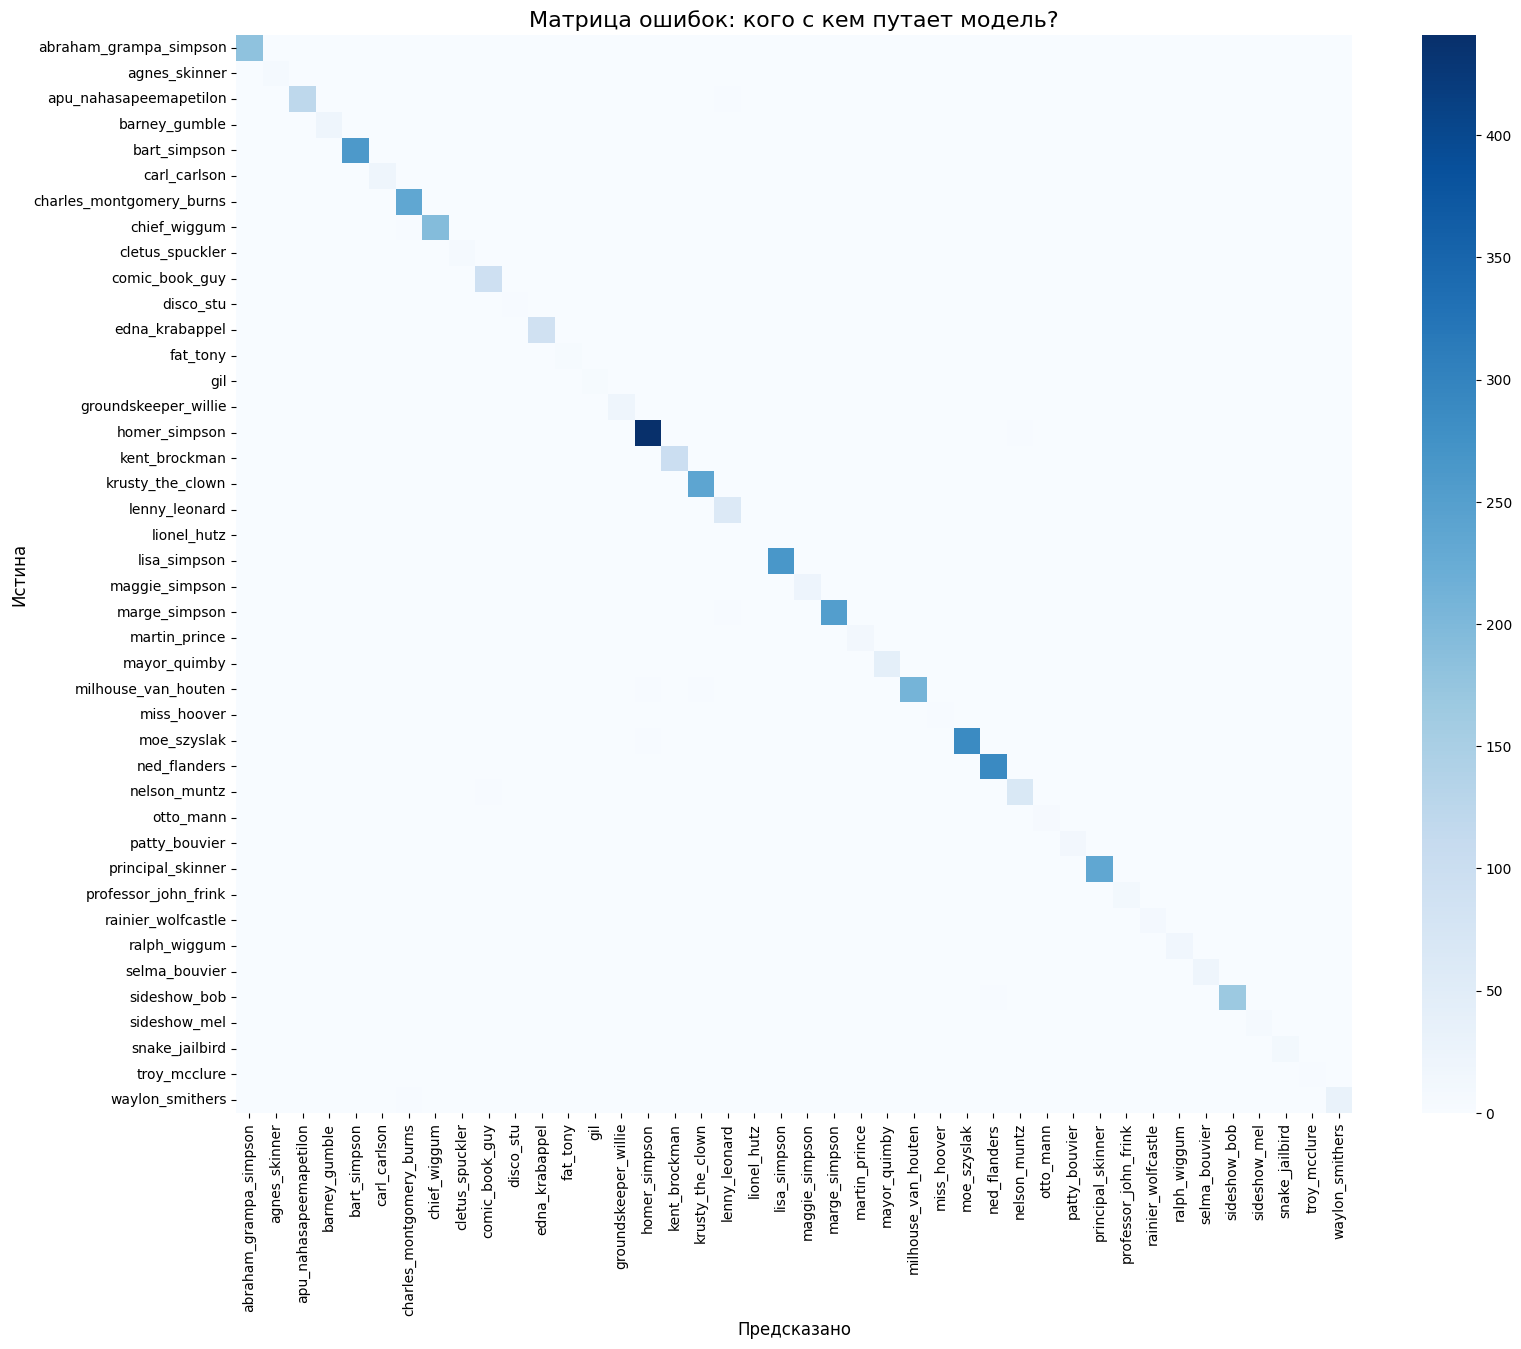


 Визуализация Grad-CAM


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/tmp/ipython-input-3875084854.py:52: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cam = np.maximum(cam, 0)


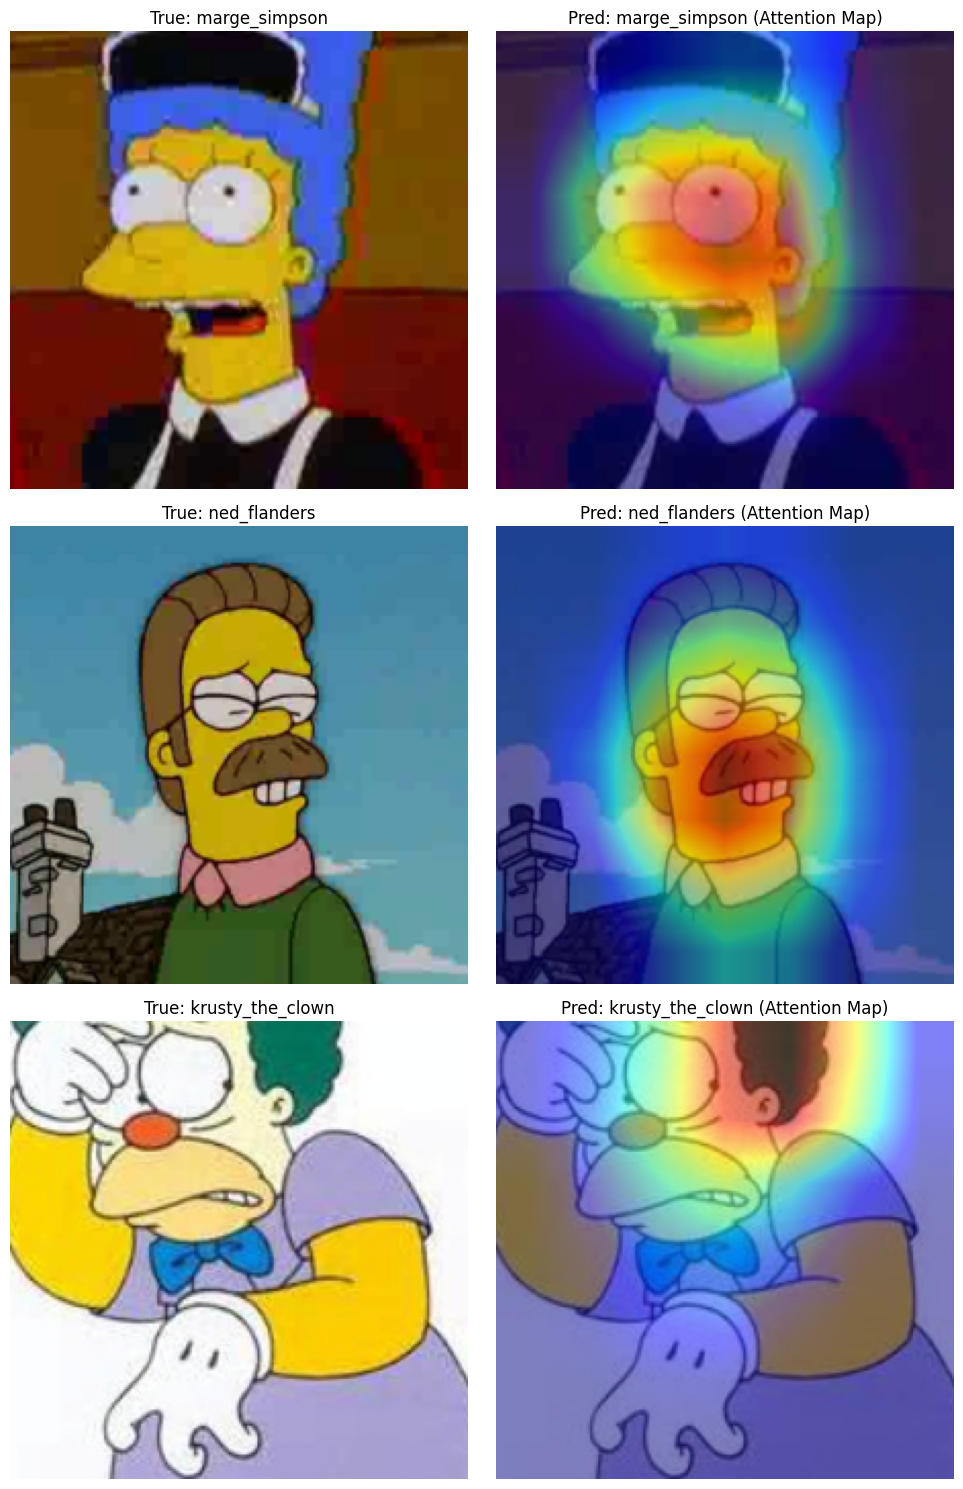

In [ ]:
# диагностика и анализ ошибок
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# матрица ошибок
def plot_confusion_matrix(model, val_loader, encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.to(DEVICE))
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(18, 14))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title('Матрица ошибок: кого с кем путает модель?', fontsize=16)
    plt.xlabel('Предсказано', fontsize=12)
    plt.ylabel('Истина', fontsize=12)
    plt.show()

# GRAD-CAM (Визуализация внимания)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output): self.activations = output
        def backward_hook(module, grad_in, grad_out): self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, class_idx):
        output = self.model(input_image)
        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze().detach().cpu()
        cam = np.maximum(cam, 0)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.numpy()

def visualize_gradcam(model, dataset, encoder, n_samples=3):
    # Берем последний конволюционный слой (для EfficientNet это features[8])
    if hasattr(model, 'backbone'):
        target_layer = list(model.backbone.children())[-3]
    else:
        target_layer = [m for m in model.modules() if isinstance(m, nn.Conv2d)][-1]

    cam_engine = GradCAM(model, target_layer)

    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 5 * n_samples))

    for i in range(n_samples):
        idx = np.random.randint(len(dataset))
        img_tensor, label_idx = dataset[idx]

        model.eval()
        output = model(img_tensor.unsqueeze(0).to(DEVICE))
        pred_idx = output.argmax(1).item()

        mask = cam_engine.generate(img_tensor.unsqueeze(0).to(DEVICE), pred_idx)

        img_show = img_tensor.permute(1, 2, 0).numpy()
        img_show = np.clip(img_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

        axes[i, 0].imshow(img_show)
        axes[i, 0].set_title(f"True: {encoder.classes_[label_idx]}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img_show)
        axes[i, 1].imshow(Image.fromarray(np.uint8(255 * mask)).resize((224, 224), resample=Image.BILINEAR),
                          cmap='jet', alpha=0.5)
        axes[i, 1].set_title(f"Pred: {encoder.classes_[pred_idx]} (Attention Map)")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

print("Отрисовка матрицы ошибок")
plot_confusion_matrix(model, val_loader, encoder)

val_ds = SimpsonsDataset(val_f, val_l, val_transforms)

print("\n Визуализация Grad-CAM")
visualize_gradcam(model, val_ds, encoder)